<a href="https://colab.research.google.com/github/AnastasiaKazanas/ANN-Final-Project/blob/main/Bert_FCNN/TwitterDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from sklearn.metrics.pairwise import cosine_similarity
import kagglehub
import pandas as pd
import re
import os
import nltk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import h5py
from torch.utils.data import TensorDataset, DataLoader

In [7]:
nltk.download('stopwords')
nltk.download('wordnet')

ppath = kagglehub.dataset_download("sudishbasnet/truthseekertwitterdataset2023")
dataset_dir = "/root/.cache/kagglehub/datasets/sudishbasnet/truthseekertwitterdataset2023/"

# Dynamically locate CSV
file_name = None
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if "Truth_Seeker_Model_Dataset" in file and file.endswith(".csv"):
            file_name = os.path.join(root, file)
            break

# Load the dataset
df = pd.read_csv(file_name)

print("Dataset preview:")
print(df.head())

print("\nDataset statistics:")
print(df.describe())

missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values)

# Check for missing values and drop them
df.dropna(subset=['tweet', 'BinaryNumTarget'], inplace=True)

# Rename columns
df.rename(columns={'tweet': 'text', 'BinaryNumTarget': 'label'}, inplace=True)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Dataset preview:
   Unnamed: 0      author                                          statement  \
0           0  D.L. Davis  End of eviction moratorium means millions of A...   
1           1  D.L. Davis  End of eviction moratorium means millions of A...   
2           2  D.L. Davis  End of eviction moratorium means millions of A...   
3           3  D.L. Davis  End of eviction moratorium means millions of A...   
4           4  D.L. Davis  End of eviction moratorium means millions of A...   

   target  BinaryNumTarget                 manual_keywords  \
0    True              1.0  Americans, eviction moratorium   
1    True              1.0  Americans, eviction moratorium   
2    True              1.0  Americans, eviction moratorium   
3    True              1.0  Americans, eviction moratorium   
4    True              1.0  Americans, eviction moratorium   

                                               tweet 5_label_majority_answer  \
0  @POTUS Biden Blunders - 6 Month Update\n\nInfl

In [8]:
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

df['processed_text'] = df['text'].apply(preprocess_text)

In [10]:
!git clone https://github.com/AnastasiaKazanas/ANN-Final-Project.git

Cloning into 'ANN-Final-Project'...
remote: Enumerating objects: 311, done.
remote: Counting objects: 100% (226/226), done.
remote: Compressing objects: 100% (198/198), done.
remote: Total 311 (delta 95), reused 37 (delta 27), pack-reused 85 (from 1)
Receiving objects: 100% (311/311), 61.38 MiB | 33.20 MiB/s, done.
Resolving deltas: 100% (142/142), done.
Filtering content: 100% (4/4), 435.84 MiB | 57.81 MiB/s, done.


In [11]:
file_path = '/content/ANN-Final-Project/Bert_embeding_datasets/Fake_News_Classification.h5'

with h5py.File(file_path, 'r') as f:
    input_ids = np.array(f['input_ids'])
    labels = np.array(f['labels'])

# Convert to PyTorch tensors
input_ids = torch.tensor(input_ids, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)

# Split data
X_train, X_test, y_train, y_test = train_test_split(input_ids, labels, test_size=0.2, random_state=42)

# Create Tensor datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [12]:
# FCNN
class FullyConnectedModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FullyConnectedModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Model
input_size = input_ids.shape[1]
hidden_size = 100
num_classes = 2

model = FullyConnectedModel(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 5
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 0.5966
Epoch [2/5], Loss: 0.5671
Epoch [3/5], Loss: 0.7453
Epoch [4/5], Loss: 0.5771
Epoch [5/5], Loss: 0.6288


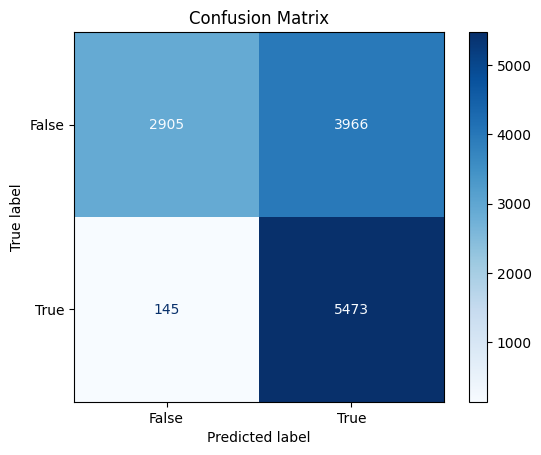

Accuracy of the model on the test data: 0.67


In [13]:
model.eval()
all_preds = []
all_targets = []

correct = 0
total = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.tolist())
        all_targets.extend(targets.tolist())

        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = correct / total

# Confusion matrix
conf_matrix = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['False', 'True'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

print(f'Accuracy of the model on the test data: {accuracy:.2f}')
